# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

training_file = "traffic-signs-data/train.p"
validation_file= "traffic-signs-data/valid.p"
testing_file = "traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
import numpy as np
import pandas as pd
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

n_train = np.shape(X_train)[0]
n_valid = np.shape(X_valid)[0]
n_test = np.shape(X_test)[0]

image_shape = np.shape(X_train)[1:4]

# Unique classes/labels there are in the dataset.
n_classes = len(pd.Series(y_train).value_counts())

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory visualization of the dataset

In [3]:
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

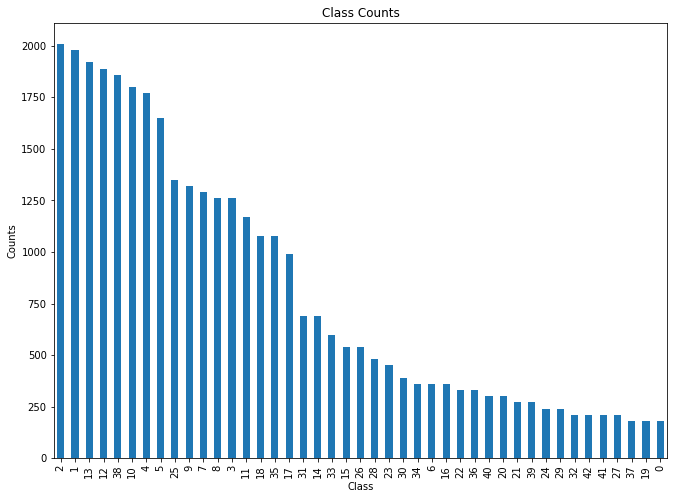

In [4]:
#Show class distribution
train_labels = pd.DataFrame(y_train,columns=['label'])
train_labels_cnts = train_labels['label'].value_counts()
pd_plot = train_labels_cnts.plot(kind='bar',figsize=(11, 8),title="Class Counts");
pd_plot.set_xlabel("Class")
pd_plot.set_ylabel("Counts")

In [5]:
print("Largest Class is 2 with",len(X_train[y_train == 2]))
print("Smallest class is 0 wth",len(X_train[y_train == 0]))

Largest Class is 2 with 2010
Smallest class is 0 wth 180


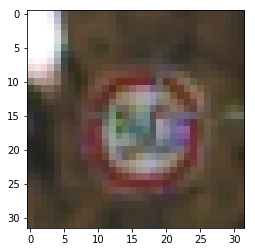

In [6]:
#Show a picture from class 2 (Speed limit (50km/h))
plt.imshow(X_train[y_train == 2][0])

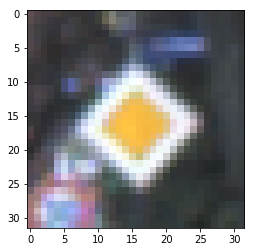

In [7]:
#Show a picture from class 12 (Priority road)
plt.imshow(X_train[y_train == 12][0])

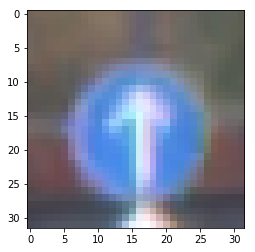

In [8]:
#Show a picture from class 35 (Ahead only)
plt.imshow(X_train[y_train == 35][0])

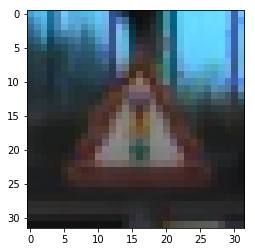

In [9]:
#Show a picture from class 26 (Traffic signals)
plt.imshow(X_train[y_train == 26][0])

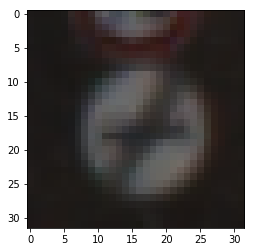

In [10]:
#Show a picture from class 41 (End of no passing)
plt.imshow(X_train[y_train == 41][0])

### Pre-process the Data Set

In [11]:
import random
from sklearn.utils import shuffle
import math
import cv2

# Rotate image CW or CCW from 5 to 25 degrees
def rotate_image(img):
    rows,cols,chans = np.shape(img)
    ran_sample = [-5,-4,-3,-2,-1,1,2,3,4,5]
    
    colMid = cols/2
    rowMid = rows/2
    
    num = random.sample(ran_sample,1)[0]
    rotMat = cv2.getRotationMatrix2D((colMid,rowMid),(num*5),1)
    modImg = cv2.warpAffine(img,rotMat,(cols,rows))
    return modImg
 
# This function will normalize image to have pixel value between -1 and 1 
# Vectorized version
def normalize_image_set(imgSet):
    modImgSet = np.multiply(imgSet,(2/255))-1.
    return modImgSet

# Set pixel value to 0 for 20% of the image, should be used after normalization
def pixel_dropout(img):
    rows,cols,chans = np.shape(img)
    modImg = np.copy(img)
        
    ranX = random.sample(range(rows*cols), int(rows*cols*0.1))
    ranY = random.sample(range(rows*cols), int(rows*cols*0.1))

    modImg[np.mod(ranX,rows).ravel(),np.mod(ranY,cols).ravel()] = 0
    
    return modImg

# shrink image after normalization so image is padded with 0 not -1
def shrink_image(img):
    rows,cols,chans = np.shape(img)
    # create blank image of rows,cols because of shrinkage 
    modImg = np.zeros((rows,cols,chans))
    num = random.randint(0,1)
    scale = 0.9 if num == 0 else 0.8
    adj_r1 = int((rows-int(scale*rows))/2)
    adj_r2 = rows-int(scale*rows) - adj_r1

    adj_c1 = int((cols-int(scale*cols))/2)
    adj_c2 = cols-int(scale*cols) - adj_c1

    t_rz_img = cv2.resize(img,(int(scale*rows), int(scale*cols)), interpolation = cv2.INTER_AREA)
    modImg[adj_r1:rows-adj_r2, adj_c1:cols-adj_c2] += t_rz_img
    return modImg

def enlarg_image(img):
    rows,cols,chans = np.shape(img)
    # create blank image of rows,cols because of enlargment
    modImg = np.zeros((rows,cols,chans))
    num = random.randint(0,1)
    scale = 1.1 if num == 0 else 1.2
    adj_r = int((int(scale*rows)-rows)/2)

    adj_c = int((int(scale*cols)-cols)/2)

    t_rz_img = cv2.resize(img,(int(scale*rows), int(scale*cols)))
    
    modImg += t_rz_img[adj_r:adj_r+rows, adj_c:adj_c+cols]
    return modImg

def shift_image(img):
    rows,cols,chans = np.shape(img)
    ran_sample = [-10,-5,5,10]
    
    colShf = random.sample(ran_sample, 1)[0]
    rowShf = random.sample(ran_sample, 1)[0]
    
    M = np.float32([[1,0,colShf],[0,1,rowShf]])
    
    #shift with 0
    modImg = cv2.warpAffine(img,M,(cols,rows))
    return modImg

# Generate modified image based randomly selected image of image set
def generate_mod_image_set(imgSet, cnt): 
    modImgSet = np.array([])
    sample,rows,cols,chans = np.shape(imgSet)
    for i in range(cnt):
        #choose randome iamge
        img_idx = random.randint(0,sample-1)
        choice = random.randint(0,4)
        if choice == 0:
            modImg = rotate_image(imgSet[img_idx])
        elif choice == 1:
            modImg = pixel_dropout(imgSet[img_idx])
        elif choice == 2:
            modImg = shrink_image(imgSet[img_idx])
        elif choice == 3:
            modImg = enlarg_image(imgSet[img_idx])
        else:
            modImg = shift_image(imgSet[img_idx])
        
        modImgSet = np.append(modImgSet,modImg)
        
    #reshape modImgSet                
    modImgSet = np.reshape(modImgSet,(cnt,rows,cols,chans))
    return modImgSet

# Generate copy of iamges to balance out class set
def generate_cpy_image_set(imgSet, cnt):
    modImgSet = np.array([])
    sample,rows,cols,chans = np.shape(imgSet)
    full_cpys = math.floor(cnt/float(sample))
    if full_cpys > 0 and cnt%sample == 0:
        for i in range(full_cpys):
            modImgSet = np.append(modImgSet,imgSet)
    elif full_cpys > 0 and cnt%sample != 0:
        for i in range(full_cpys):
            modImgSet = np.append(modImgSet,imgSet)
        for j in range(int(cnt-(full_cpys*sample))):
            img_idx = random.randint(0,sample-1)
            modImgSet = np.append(modImgSet,imgSet[img_idx])
    else:
        for i in range(cnt):
            img_idx = random.randint(0,sample-1)
            modImgSet = np.append(modImgSet,imgSet[img_idx])
            
    #reshape modImgSet                
    modImgSet = np.reshape(modImgSet,(cnt,rows,cols,chans))
    return modImgSet       

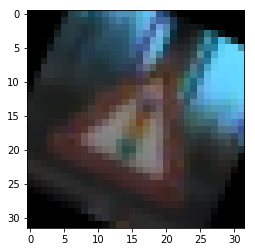

In [12]:
#Example Usage of rotate_image
test_img = X_train[y_train == 26][0]
plt.imshow(rotate_image(test_img))

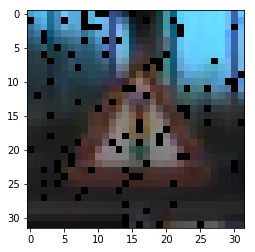

In [13]:
#Example Usage of pixel_dropout
plt.imshow(pixel_dropout(test_img))

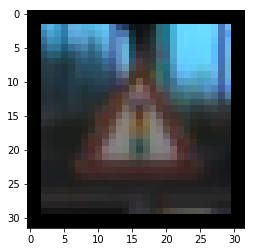

In [14]:
#Example of shrink
plt.imshow(np.uint8(shrink_image(test_img)))

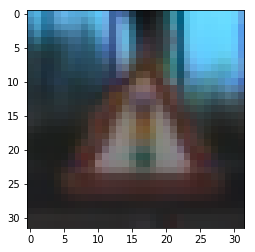

In [15]:
#Example of enlarge
plt.imshow(np.uint8(enlarg_image(test_img)))

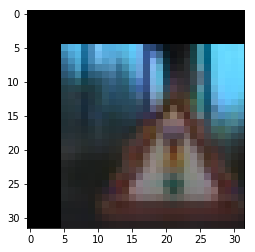

In [16]:
#Example of shift
plt.imshow(np.uint8(shift_image(test_img)))

In [17]:
#normalize first
X_train_norm = normalize_image_set(X_train)

#shuffle iamge set
X_train_norm, y_train_norm = shuffle(X_train_norm, y_train)

In [18]:
#make sure every class has 2010 images
tx_train_mod = ty_train_mod = np.array([])
for cla in range(n_classes):
    c_img_set = X_train_norm[y_train_norm == cla]
    tx_train_mod = np.append(tx_train_mod,generate_cpy_image_set(c_img_set,2010))
    ty_train_mod = np.append(ty_train_mod,[cla]*2010)

In [19]:
#reshape
rows,cols,chans = np.shape(test_img)
tx_train_mod = np.reshape(tx_train_mod,(len(ty_train_mod),rows,cols,chans)) 

In [20]:
#verify classes all have 2010 images
ty_train_mod_df = pd.DataFrame(ty_train_mod,columns=['label'])
ty_train_mod_df = ty_train_mod_df['label'].value_counts()
ty_train_mod_df

15.0    2010
22.0    2010
35.0    2010
26.0    2010
34.0    2010
41.0    2010
24.0    2010
20.0    2010
3.0     2010
17.0    2010
29.0    2010
40.0    2010
10.0    2010
33.0    2010
18.0    2010
25.0    2010
32.0    2010
8.0     2010
4.0     2010
2.0     2010
14.0    2010
42.0    2010
21.0    2010
11.0    2010
7.0     2010
39.0    2010
38.0    2010
13.0    2010
28.0    2010
6.0     2010
19.0    2010
31.0    2010
5.0     2010
30.0    2010
37.0    2010
27.0    2010
36.0    2010
16.0    2010
12.0    2010
1.0     2010
9.0     2010
23.0    2010
0.0     2010
Name: label, dtype: int64

In [21]:
# Construct modified training set
# Review:
# 1) Normalize
# 2) Generate copies so each class has 2010 iamges
# 3) Now modify 35% of the images to be either rotated,pixel dropout,shrink,enlarge
tx_train_mod, ty_train_mod = shuffle(tx_train_mod, ty_train_mod)
X_train_mod = y_train_mod = np.array([])
idx_35 = int(0.35*2010)
for cla in range(n_classes):
    c_img_set = tx_train_mod[ty_train_mod == cla]
    X_train_mod = np.append(X_train_mod,generate_mod_image_set(c_img_set,idx_35))
    X_train_mod = np.append(X_train_mod,c_img_set[idx_35:])
    y_train_mod = np.append(y_train_mod,[cla]*2010)

In [22]:
#Reshape x_train_mod
rows,cols,chans = np.shape(test_img)
X_train_mod = np.reshape(X_train_mod,(len(y_train_mod),rows,cols,chans)) 

In [23]:
#Verify each class still has 2010 images
y_train_mod_df = pd.DataFrame(y_train_mod,columns=['label'])
y_train_mod_df = y_train_mod_df['label'].value_counts()
y_train_mod_df

15.0    2010
22.0    2010
35.0    2010
26.0    2010
34.0    2010
41.0    2010
24.0    2010
20.0    2010
3.0     2010
17.0    2010
29.0    2010
40.0    2010
10.0    2010
33.0    2010
18.0    2010
25.0    2010
32.0    2010
8.0     2010
4.0     2010
2.0     2010
14.0    2010
42.0    2010
21.0    2010
11.0    2010
7.0     2010
39.0    2010
38.0    2010
13.0    2010
28.0    2010
6.0     2010
19.0    2010
31.0    2010
5.0     2010
30.0    2010
37.0    2010
27.0    2010
36.0    2010
16.0    2010
12.0    2010
1.0     2010
9.0     2010
23.0    2010
0.0     2010
Name: label, dtype: int64

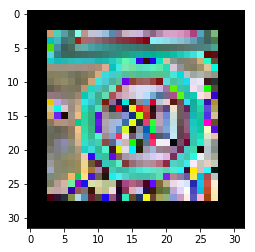

In [24]:
#Take a look at an image to make sure class and modification worked
plt.imshow(X_train_mod[y_train_mod==0][500])

In [25]:
#Save data set at pickle binary
training_file_mod = "traffic-signs-data/train_mod.p"
pickle.dump({'train_data':X_train_mod ,'label':y_train_mod}, open(training_file_mod,"wb"))

In [17]:
# Load training data with modified iamges
training_file_mod = "traffic-signs-data/train_mod.p"
with open(training_file_mod, mode='rb') as f:
    train2 = pickle.load(f)
 
X_train_mod, y_train_mod = train2['train_data'], train2['label']

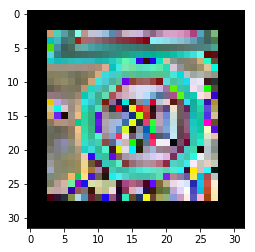

In [18]:
#Take a look at an image to make sure class and modification worked
plt.imshow(X_train_mod[y_train_mod==0][500])

### Model Architecture

In [19]:
import tensorflow as tf
print(tf.__version__)
from sklearn.utils import shuffle

1.0.0


#### Final Model
Overview: The model started from a quest to learn about inception. IncepRes is mainly based on Google's Inception-ResNet-v2 that produced the best result on ILSVRC 2012 in a publication (https://arxiv.org/pdf/1602.07261.pdf). Output shape are specified like (17x17x20) 

<figure>
 <figcaption>
 <p></p> 
 <p style="text-align: center; bold"> <b>IncepRes Architecture</b></p> 
 </figcaption>
 <img src="IncepRes.png" width="380" height="600" alt="IncepRes Architecture" />
</figure>
 <p></p> 

Next to layer name; filter size (e.g. 3x3), stride (e.g. S1) and padding (e.g. V) are displayed. The picture below describes the "Stem" of the architecture. The purpose of the stem is to reduce the size of image from 32x32 to 17x17. I arbitrarily choose a depth of 20 layers (4 more than LeNet). I used convolution and max pooling layers without relu activation to reduce the size.

<figure>
 <figcaption>
 <p></p> 
 <p style="text-align: center; bold"> <b>Stem Sub-Architecture</b></p> 
 </figcaption>
 <img src="Stem.png" width="280" alt="Stem Sub-Architecture" />
</figure>
 <p></p>
 
Next is Inception-ResNet-B from Google's Inception-ResNet-v2. Every layer has same padding to output the same shape as input (17x17x20). The graph does not explicit show filter concatenation when convolution branch merge, however, that is what I did. The paper also explains that residual (convolution layers) should be scaled between 0.1 and 0.3 before adding back to identity. I scaled the last 1x1 convolution layer with Batch Normalization with scaling of 0.3.

<figure>
 <figcaption>
 <p></p> 
 <p style="text-align: center; bold"> <b>Inception-ResNet-B Sub-Architecture</b></p> 
 </figcaption>
 <img src="Inception-ResNet-B.png" width="280" alt="Inception-ResNet-B Sub-Architecture" />
</figure>
 <p></p>

Then I modified Reduction-B to reduce 17x17x20 down to 8x8x84. The depth of convolution consists of 3 layers of 20 deep and 1 layer of 24 deep.  

<figure>
 <figcaption>
 <p></p> 
 <p style="text-align: center; bold"> <b>Reduction-B Sub-Architecture</b></p> 
 </figcaption>
 <img src="Reduction-B.png" width="280" alt="Reduction-B Sub-Architecture" />
</figure>
 <p></p>
 
Since 84 was like the number of Fully Connected nodes at the end of LeNet, the last part of the architecture further reduces 8x8x84 to 1x1x84. I tested with dropout and keep probability of 0.8, 0.88, 0.9, and 1.0. 

I also test with adding 3 more Inception-ResNet-C (IncepRes_V1), with size 3x3x84, after reducing 8x8x84 to 3x3x84. The resulting validation accuracy was much less compared to final model.  


In [20]:
from tensorflow.contrib.layers import flatten

def stemBlock(x,mu=0.,sigma=0.1):
    # This stem reduce dimension from 32x32x3 to 17x17x20
    # filter weights: (height, width, input_depth, output_depth)
        
    # for valid padding:
    # out_height = ceil(float(in_height - filter_height + 1) / float(strides[1]))
    # out_width  = ceil(float(in_width - filter_width + 1) / float(strides[2]))
    # stride: (batch (1),height,width,channel (1))
    
    l_stride = [1,1,1,1]
    
    # ***************************   Layer 1  **********************************************************************
    # Convolutional. Input = 32x32x3. Output = 28x28x8.
    l1_conv_W = tf.Variable(tf.truncated_normal(shape=(5,5,3,8),mean=mu,stddev=sigma))
    l1_conv_b = tf.Variable(tf.zeros(8))
    l1_conv_a = tf.nn.conv2d(x,l1_conv_W,strides=l_stride,padding='VALID') + l1_conv_b
    
    # ***************************   Layer 2  **********************************************************************
    # Convolutional. Input = 28x28x8. Output = 24x24x8.
    l2_conv_W = tf.Variable(tf.truncated_normal(shape=(5,5,8,8),mean=mu,stddev=sigma))
    l2_conv_b = tf.Variable(tf.zeros(8))
    l2_conv_a = tf.nn.conv2d(l1_conv_a,l2_conv_W,strides=l_stride,padding='VALID') + l2_conv_b
    
    # ***************************   Layer 3  **********************************************************************
    # Max Pool. Input = 24x24x8. Output = 22x22x8.
    # new_height = (input_height - filter_height)/S + 1
    # new_width = (input_width - filter_width)/S + 1
    l3_pool_a = tf.nn.max_pool(l2_conv_a,ksize=[1,3,3,1],strides=l_stride,padding='VALID')
    
    # ***************************   Layer 4  **********************************************************************
    # Convolutional. Input = 22x22x8. Output = 20x20x20.
    l4_conv_W = tf.Variable(tf.truncated_normal(shape=(3,3,8,20),mean=mu,stddev=sigma))
    l4_conv_b = tf.Variable(tf.zeros(20))
    l4_conv_a = tf.nn.conv2d(l3_pool_a,l4_conv_W,strides=l_stride,padding='VALID') + l4_conv_b
    
    # ***************************   Layer 5  **********************************************************************
    # Convolutional. Input = 20x20x20. Output = 18x18x20.
    l5_conv_W = tf.Variable(tf.truncated_normal(shape=(3,3,20,20),mean=mu,stddev=sigma))
    l5_conv_b = tf.Variable(tf.zeros(20))
    l5_conv_a = tf.nn.conv2d(l4_conv_a,l5_conv_W,strides=l_stride,padding='VALID') + l5_conv_b
    
    # ***************************   Layer 6  **********************************************************************
    # Max Pool. Input = 18x18x20. Output = 17x17x20.
    # new_height = (input_height - filter_height)/S + 1
    # new_width = (input_width - filter_width)/S + 1
    a_stem = tf.nn.max_pool(l5_conv_a,ksize=[1,2,2,1],strides=l_stride,padding='VALID')
    return a_stem

# This is called after stemBlock. Input = 17x17x20. Output = 17x17x20
def subIncepResB(x,mu=0.,sigma=0.1,scale=0.3,mode='TRAIN'):
    l_stride = [1,1,1,1]
    
    # ***************************   Layer 1  **********************************************************************
    # Convolutional. Input = 17x17x20. Output = 17x17x20. 1x1 convolution
    l1_conv_W = tf.Variable(tf.truncated_normal(shape=(1,1,20,20),mean=mu,stddev=sigma))
    l1_conv_b = tf.Variable(tf.zeros(20))
    l1_conv_a = tf.nn.conv2d(x,l1_conv_W,strides=l_stride,padding='SAME') + l1_conv_b
    
    # ***************************   Layer 1a **********************************************************************
    # Convolutional. Input = 17x17x20. Output = 17x17x20. 
    l1a_conv_W = tf.Variable(tf.truncated_normal(shape=(1,7,20,20),mean=mu,stddev=sigma))
    l1a_conv_b = tf.Variable(tf.zeros(20))
    l1a_conv_a = tf.nn.conv2d(l1_conv_a,l1a_conv_W,strides=l_stride,padding='SAME') + l1a_conv_b
    
    # ***************************   Layer 1b **********************************************************************
    # Convolutional. Input = 17x17x20. Output = 17x17x20.  
    l1b_conv_W = tf.Variable(tf.truncated_normal(shape=(7,1,20,20),mean=mu,stddev=sigma))
    l1b_conv_b = tf.Variable(tf.zeros(20))
    l1b_conv_a = tf.nn.conv2d(l1a_conv_a,l1b_conv_W,strides=l_stride,padding='SAME') + l1b_conv_b
    
    # ***************************   Layer 2  **********************************************************************
    # Concatinate. Output = 17x17x40
    l2_concat_a = tf.concat([l1_conv_a, l1b_conv_a], axis=3)
    
    # ***************************   Layer 3  **********************************************************************
    # Convolutional. Input = 17x17x40. Output = 17x17x20. 1x1 convolution
    l3_conv_W = tf.Variable(tf.truncated_normal(shape=(1,1,40,20),mean=mu,stddev=sigma))
    l3_conv_b = tf.Variable(tf.zeros(20))
    l3_conv_a = tf.nn.conv2d(l2_concat_a,l3_conv_W,strides=l_stride,padding='SAME') + l3_conv_b
    
    # Scale Layer 3 Use Batch Normalization with scaling if in training mode
    # Have to normalize or validation accuracy is low
    # Per documentation: For so-called "global normalization", 
    # used with convolutional filters with shape [batch, height, width, depth], pass axes=[0, 1, 2].
    a_mu,a_var = tf.nn.moments(l3_conv_a,axes=[0, 1, 2]) # calculate for batch normalization
    # Variance epsilon: A small float number to avoid dividing by 0.
    res_bn_a = tf.nn.batch_normalization(l3_conv_a,mean=a_mu,variance=a_var,offset=None,scale=scale,variance_epsilon=0.0001)
    res_a = res_bn_a
    
    # Add residule to identity
    res_a = tf.add(x,res_a)
    
    # Activation
    res_z = tf.nn.relu(res_a)
    
    return res_z

# Input = 3x3x84. Output = 3x3x84
def subIncepResC(x,mu=0.,sigma=0.1,scale=0.3,mode='TRAIN'):
    l_stride = [1,1,1,1]
    
    # ***************************   Layer 1  **********************************************************************
    # Convolutional. Input = 3x3x84. Output = 3x3x84. 1x1 convolution
    l1_conv_W = tf.Variable(tf.truncated_normal(shape=(1,1,84,84),mean=mu,stddev=sigma))
    l1_conv_b = tf.Variable(tf.zeros(84))
    l1_conv_a = tf.nn.conv2d(x,l1_conv_W,strides=l_stride,padding='SAME') + l1_conv_b
    
    # ***************************   Layer 1a **********************************************************************
    # Convolutional. Input = 3x3x84. Output = 3x3x84. 
    l1a_conv_W = tf.Variable(tf.truncated_normal(shape=(1,3,84,84),mean=mu,stddev=sigma))
    l1a_conv_b = tf.Variable(tf.zeros(84))
    l1a_conv_a = tf.nn.conv2d(l1_conv_a,l1a_conv_W,strides=l_stride,padding='SAME') + l1a_conv_b
    
    # ***************************   Layer 1b **********************************************************************
    # Convolutional. Input = 3x3x84. Output = 3x3x84.  
    l1b_conv_W = tf.Variable(tf.truncated_normal(shape=(3,1,84,84),mean=mu,stddev=sigma))
    l1b_conv_b = tf.Variable(tf.zeros(84))
    l1b_conv_a = tf.nn.conv2d(l1a_conv_a,l1b_conv_W,strides=l_stride,padding='SAME') + l1b_conv_b
    
    # ***************************   Layer 2  **********************************************************************
    # Concatinate. Output = 3x3x168
    l2_concat_a = tf.concat([l1_conv_a, l1b_conv_a], axis=3)
    
    # ***************************   Layer 3  **********************************************************************
    # Convolutional. Input = 3x3x168. Output = 3x3x84. 1x1 convolution
    l3_conv_W = tf.Variable(tf.truncated_normal(shape=(1,1,168,84),mean=mu,stddev=sigma))
    l3_conv_b = tf.Variable(tf.zeros(84))
    l3_conv_a = tf.nn.conv2d(l2_concat_a,l3_conv_W,strides=l_stride,padding='SAME') + l3_conv_b
    
    # Scale Layer 3 Use Batch Normalization with scaling
    # Have to normalize or validation accuracy is low
    # Per documentation: For so-called "global normalization", 
    # used with convolutional filters with shape [batch, height, width, depth], pass axes=[0, 1, 2].
    a_mu,a_var = tf.nn.moments(l3_conv_a,axes=[0, 1, 2]) # calculate for batch normalization
    # Variance epsilon: A small float number to avoid dividing by 0.
    res_bn_a = tf.nn.batch_normalization(l3_conv_a,mean=a_mu,variance=a_var,offset=None,scale=scale,variance_epsilon=0.0001)
    res_a = res_bn_a
  
    # Add residule to identity
    res_a = tf.add(x,res_a)
    
    # Activation
    res_z = tf.nn.relu(res_a)
    
    return res_z

# This is called after subIncepResB. Reduce 17x17x20 to 8x8x84
def reduction(x,mu=0.,sigma=0.1):
    l_stride1 = [1,1,1,1]
    l_stride2 = [1,2,2,1]
    
    # ***************************   Branch 1  **********************************************************************
    # Max Pool. Input = 17x17x20. Output = 8x8x20. 
    b1_pool_a = tf.nn.max_pool(x,ksize=[1,3,3,1],strides=l_stride2,padding='VALID')
    
    # ***************************   Branch 2  **********************************************************************
    # Convolutional. Input = 17x17x20. Output = 17x17x20. 1x1 convolution
    b2_conv_W = tf.Variable(tf.truncated_normal(shape=(1,1,20,20),mean=mu,stddev=sigma))
    b2_conv_b = tf.Variable(tf.zeros(20))
    b2_conv_a = tf.nn.conv2d(x,b2_conv_W,strides=l_stride1,padding='SAME') + b2_conv_b
    
    # ***************************   Branch 2a **********************************************************************
    # Convolutional. Input = 17x17x20. Output = 8x8x24. 
    b2a_conv_W = tf.Variable(tf.truncated_normal(shape=(3,3,20,24),mean=mu,stddev=sigma))
    b2a_conv_b = tf.Variable(tf.zeros(24))
    b2a_conv_a = tf.nn.conv2d(b2_conv_a,b2a_conv_W,strides=l_stride2,padding='VALID') + b2a_conv_b
    
    # ***************************   Branch 3a **********************************************************************
    # Convolutional. Input = 17x17x20. Output = 8x8x20. 
    b3a_conv_W = tf.Variable(tf.truncated_normal(shape=(3,3,20,20),mean=mu,stddev=sigma))
    b3a_conv_b = tf.Variable(tf.zeros(20))
    b3a_conv_a = tf.nn.conv2d(b2_conv_a,b3a_conv_W,strides=l_stride2,padding='VALID') + b3a_conv_b
    
    # ***************************   Branch 4a **********************************************************************
    # Convolutional. Input = 17x17x20. Output = 17x17x20. 
    b4a_conv_W = tf.Variable(tf.truncated_normal(shape=(3,3,20,20),mean=mu,stddev=sigma))
    b4a_conv_b = tf.Variable(tf.zeros(20))
    b4a_conv_a = tf.nn.conv2d(b2_conv_a,b4a_conv_W,strides=l_stride1,padding='SAME') + b4a_conv_b
    
    # ***************************   Branch 4b **********************************************************************
    # Convolutional. Input = 17x17x20. Output = 8x8x20. 
    b4b_conv_W = tf.Variable(tf.truncated_normal(shape=(3,3,20,20),mean=mu,stddev=sigma))
    b4b_conv_b = tf.Variable(tf.zeros(20))
    b4b_conv_a = tf.nn.conv2d(b4a_conv_a,b4b_conv_W,strides=l_stride2,padding='VALID') + b4b_conv_b
    
    # ***************************   Layer 2 **********************************************************************
    # Concatinate. Output = 8x8x84
    l2_concat_a = tf.concat([b1_pool_a,b2a_conv_a,b3a_conv_a,b4b_conv_a], axis=3)
    
    return l2_concat_a
    
    
# Recommended scale from 0.1 to 0.3:
# Best 95% on validation over 12 epoch
def IncepRes(x,keep_prob=1.,mu=0.,sigma=0.1,scale=0.3):
    l_padding = 'VALID'
    l_stride = [1,1,1,1]
    
    # ***************************   Layer 1  ***********************************************************************
    # Stem. Input: 32x32x3. Output: 17x17x20 
    l1_a = stemBlock(x,mu=mu,sigma=sigma)
    # Activation. Taken from begining of subIncepResB for layer consistency here
    l1_z = tf.nn.relu(l1_a)

    # ***************************   Layer 2  ***********************************************************************
    # May need to decrease sigma compared to stem because of relu activation and compounding variance
    # Activation within subIncepResB. Input: 17x17x20. Output: 17x17x20 
    l2_z = subIncepResB(l1_z,mu=mu,sigma=sigma,scale=scale)
    
    # ***************************   Layer 3  ***********************************************************************
    # May need to decrease sigma compared to layer 2 because of compounding variance
    # Input: 17x17x20. Output: 3x3x84 
    l3_a = reduction(l2_z,mu=mu,sigma=sigma)
    
    # ***************************   Layer 4 **********************************************************************
    # Added for more reduction
    # Convolutional. Input = 8x8x84. Output = 3x3x84. 
    l4_conv_W = tf.Variable(tf.truncated_normal(shape=(3,3,84,84),mean=mu,stddev=sigma))
    l4_conv_b = tf.Variable(tf.zeros(84))
    l4_conv_a = tf.nn.conv2d(l3_a,l4_conv_W,strides=[1,2,2,1],padding='VALID') + l4_conv_b
    
    # Activation
    l4_z = tf.nn.relu(l4_conv_a)
    
    # Avg Pool Input: 3x3x84. Output: 1x1x84
    l4_pool_z = tf.nn.avg_pool(l4_z,ksize=[1,3,3,1],strides=l_stride,padding='VALID')
    
    # Flatten just in case. Output: 84
    l4_flat_z = flatten(l4_pool_z)
    
    l4_do = tf.nn.dropout(l4_flat_z,keep_prob)

    # ***************************   Final   ***********************************************************************
    # Fully Connected. Input = 84. Output = 10.
    l5_fc_W = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean=mu, stddev=sigma))
    l5_fc_b = tf.Variable(tf.zeros(n_classes))
    l5_fc_a = tf.matmul(l4_do, l5_fc_W) + l5_fc_b
    
    return l5_fc_a # logits

# Best validation near 90% 
def IncepRes_V1(x,keep_prob=1.0,mu=0.,sigma=0.1,scale=0.4):
    l_padding = 'VALID'
    l_stride = [1,1,1,1]
    
    # ***************************   Layer 1  ***********************************************************************
    # Stem. Input: 32x32x3. Output: 17x17x20 
    l1_a = stemBlock(x,mu=mu,sigma=sigma)
    # Activation. Taken from begining of subIncepResB for layer consistency here
    l1_z = tf.nn.relu(l1_a)

    # ***************************   Layer 2  ***********************************************************************
    # May need to decrease sigma compared to stem because of relu activation and compounding variance
    # Activation within subIncepResB. Input: 17x17x20. Output: 17x17x20 
    l2_z = subIncepResB(l1_z,mu=mu,sigma=sigma,scale=scale)
    
    # ***************************   Layer 3  ***********************************************************************
    # May need to decrease sigma compared to layer 2 because of compounding variance
    # Input: 17x17x20. Output: 8x8x84 
    l3_a = reduction(l2_z,mu=mu,sigma=sigma)
    
    # Activation
    l3_z = tf.nn.relu(l3_a)
    
    # ***************************   Layer 4  ***********************************************************************
    # Activation within subIncepResC x 3. Input: 8x8x84. Output 8x8x84.
    l4_z = tf.nn.relu(subIncepResC(l3_z,mu=mu,sigma=sigma,scale=scale))
    l4_z = tf.nn.relu(subIncepResC(l4_z,mu=mu,sigma=sigma,scale=scale))
    l4_z = tf.nn.relu(subIncepResC(l4_z,mu=mu,sigma=sigma,scale=scale))
    
    # ***************************   Layer 5  ***********************************************************************
    # Convolutional. Input = 8x8x84. Output = 3x3x84. 
    l5_conv_W = tf.Variable(tf.truncated_normal(shape=(3,3,84,84),mean=mu,stddev=sigma))
    l5_conv_b = tf.Variable(tf.zeros(84))
    l5_conv_a = tf.nn.conv2d(l4_z,l5_conv_W,strides=[1,2,2,1],padding='VALID') + l5_conv_b
    
    # Activation
    l5_conv_z = tf.nn.relu(l5_conv_a)
    
    # Avg Pool Input: 3x3x84. Output: 1x1x84
    l5_pool_z = tf.nn.avg_pool(l5_conv_z,ksize=[1,3,3,1],strides=l_stride,padding='VALID')
    
    # Flatten just in case. Output: 84
    l5_flat_z = flatten(l5_pool_z)
    
    l5_do = tf.nn.dropout(l5_flat_z,keep_prob)

    # ***************************   Final   ***********************************************************************
    # Fully Connected. Input = 84. Output = 43.
    l6_fc_W = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean=mu, stddev=sigma))
    l6_fc_b = tf.Variable(tf.zeros(n_classes))
    l6_fc_a = tf.matmul(l5_do, l6_fc_W) + l6_fc_b
    
    return l6_fc_a # logits

# LeNet Copy Best validation near 88% 
def LeNet_Cpy(x,mu=0.,sigma=0.1):
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.avg_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.avg_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Train, Validate and Test the Model

In [21]:
#Normalize validation and test set
X_valid_norm = normalize_image_set(X_valid)
X_test_norm = normalize_image_set(X_test)

In [22]:
#Reset variables if needed
tf.reset_default_graph()

In [23]:
X = tf.placeholder(tf.float32, (None, 32, 32, 3)) # To feed in image set
y = tf.placeholder(tf.int32, (None)) # To feed in class labels
p_keep_prob = tf.placeholder(tf.float32)
p_rate = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, n_classes)

In [24]:
# Training pipeline
# Build IncepRes and store final logits vector
logits = IncepRes(X,p_keep_prob,0.,0.1,0.3)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y,logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
# Adam optimizer have beta1=0.9 and beta2=0.999 by default, which emperically produced the best results for most cases 
optimizer = tf.train.AdamOptimizer(learning_rate = p_rate)
training_operation = optimizer.minimize(loss_operation)

In [25]:
# Model evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

saver = tf.train.Saver()

BATCH_SIZE = 265

def evaluate(X_data, y_data, keep_prob):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()

    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={X: batch_x, y: batch_y, p_keep_prob: keep_prob})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [26]:
# Create variables to keep track of which hyperparameter leads to the best results
best_valid_accuracy = 0
best_keep = 0
best_a = 0
best_epoch = 0
best_b = 0

In [60]:
# This is a script to try different hyperparamter and save best model
config = tf.ConfigProto()
config.gpu_options.allow_growth=True # Reset GPU Memory
config.gpu_options.per_process_gpu_memory_fraction = 1.0 # Allow GPU to all memory

# Train the model
EPOCHS = 41

with tf.Session(config=config) as sess:
    
    num_examples = len(X_train_mod)
    
    print("Training...")
    print()
    for times in range(5):
        for b in [256]: #batch size also tried 256      
            for a in [0.001]: # # 0.001 .978  
                for k in [0.88]: # keep_prob # 0.9 produce 98.4, tried 0.8, 1.0,0.5
                    sess.run(tf.global_variables_initializer())
                    average_valid_accuracy = 0
                    i=0
                    BATCH_SIZE = b
                    while i<EPOCHS:
                        # Shuffle input
                        X_train_mod, y_train_mod = shuffle(X_train_mod, y_train_mod)
                        for offset in range(0, num_examples, BATCH_SIZE):
                            end = offset + BATCH_SIZE
                            batch_x, batch_y = X_train_mod[offset:end], y_train_mod[offset:end]
                            sess.run(training_operation,feed_dict={X: batch_x, y: batch_y, p_keep_prob: k, p_rate: a})

                        train_accuracy = evaluate(X_train_mod, y_train_mod, 1.0)
                        validation_accuracy = evaluate(X_valid_norm, y_valid, 1.0)

                        # Moving average of validation accuracy (last 5)
                        average_valid_accuracy = ((4/5)*average_valid_accuracy) + ((1/5)*validation_accuracy)    

                        ''' # Do not know to use saved best valid accuracy because of global init
                        if validation_accuracy > sess.run(best_valid_accuracy):
                            tf.Variable.assign(self=best_valid_accuracy, value=validation_accuracy)
                            saver.save(sess, './inception')
                        '''

                        if validation_accuracy > best_valid_accuracy:
                            best_valid_accuracy = validation_accuracy
                            best_keep = k
                            best_a = a
                            best_epoch = i
                            best_b = b
                            saver.save(sess, './inception_cpy')

                        if i%20 == 0 or best_valid_accuracy == validation_accuracy :
                            print("EPOCH {} ...".format(i+1))
                            print("Training Accuracy = {:.5f}".format(train_accuracy))
                            print("Validation Accuracy = {:.5f}".format(validation_accuracy))
                            print("AVG Validation Accuracy = {:.5f}".format(average_valid_accuracy))
                            print("Best Validation Accuracy = {:.5f}".format(best_valid_accuracy))
                            print()

                        i += 1         

                        # Break if overfitting is detected
                        if validation_accuracy < 0.95*average_valid_accuracy:
                            break

Training...

EPOCH 1 ...
Training Accuracy = 0.80805
Validation Accuracy = 0.79093
AVG Validation Accuracy = 0.15819
Best Validation Accuracy = 0.98141

EPOCH 21 ...
Training Accuracy = 0.95916
Validation Accuracy = 0.96304
AVG Validation Accuracy = 0.95189
Best Validation Accuracy = 0.98141

EPOCH 41 ...
Training Accuracy = 0.97584
Validation Accuracy = 0.97687
AVG Validation Accuracy = 0.97067
Best Validation Accuracy = 0.98141

EPOCH 1 ...
Training Accuracy = 0.81151
Validation Accuracy = 0.75986
AVG Validation Accuracy = 0.15197
Best Validation Accuracy = 0.98141

EPOCH 21 ...
Training Accuracy = 0.96170
Validation Accuracy = 0.96939
AVG Validation Accuracy = 0.95301
Best Validation Accuracy = 0.98141

EPOCH 41 ...
Training Accuracy = 0.97302
Validation Accuracy = 0.96485
AVG Validation Accuracy = 0.96593
Best Validation Accuracy = 0.98141

EPOCH 1 ...
Training Accuracy = 0.81140
Validation Accuracy = 0.74467
AVG Validation Accuracy = 0.14893
Best Validation Accuracy = 0.98141

EPO

In [89]:
# Print hyperparameters that lead to the best validation accuracy
print("Best Validation Accuracy:",best_valid_accuracy)
print("Best Keep_prob:",best_keep)
print("Best learning rate:", best_a)
print("Best Epoch:",best_epoch)
print("Best Batch:",best_b)

Best Validation Accuracy: 0.981405895178
Best Keep_prob: 0.88
Best learning rate: 0.001
Best Epoch: 33
Best Batch: 256


In [90]:
# Print result of best saved model
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    print("Training:",evaluate(X_train_mod, y_train_mod, 1.0))
    print("Validation:",evaluate(X_valid_norm, y_valid, 1.0))
    print("Test:",evaluate(X_test_norm, y_test, 1.0))   

Training: 0.971757517456
Validation: 0.982766456142
Test: 0.955819511003


---

## Test Model on New Images


In [30]:
#Script to import new images as size 32x32x3
import os
import matplotlib.image as mpimg
X_test_net = y_test_net = np.array([])
imgFiles = os.listdir('testImgs')
for imgName in imgFiles:
    c = int(imgName[:-4]) #Remove .png and conver to int
    if c > 100:
        c -= 100 # 103 represent another image with class label of 3
    img = mpimg.imread('testImgs/'+imgName,format='RGB')[:,:,:3]
    # resize to 32x32
    img = cv2.resize(img,(32, 32), interpolation = cv2.INTER_AREA)
    
    X_test_net = np.append(X_test_net,img)
    y_test_net = np.append(y_test_net,c)
    
#reshape
X_test_net = np.uint8(np.reshape(X_test_net,(len(y_test_net),32,32,3)))
y_test_net = np.uint8(y_test_net)

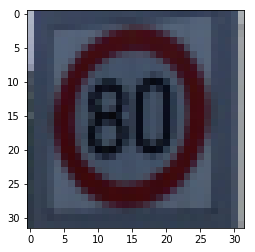

In [31]:
# Check image
plt.imshow(X_test_net[1])

In [32]:
# Check that lable match
y_test_net[1]

5

In [33]:
# normalize test images from internet
X_test_net_norm = normalize_image_set(X_test_net)

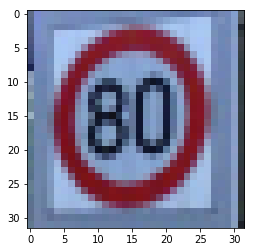

In [34]:
# Check normalization
plt.imshow(X_test_net_norm[1])

### Load and Output the Images

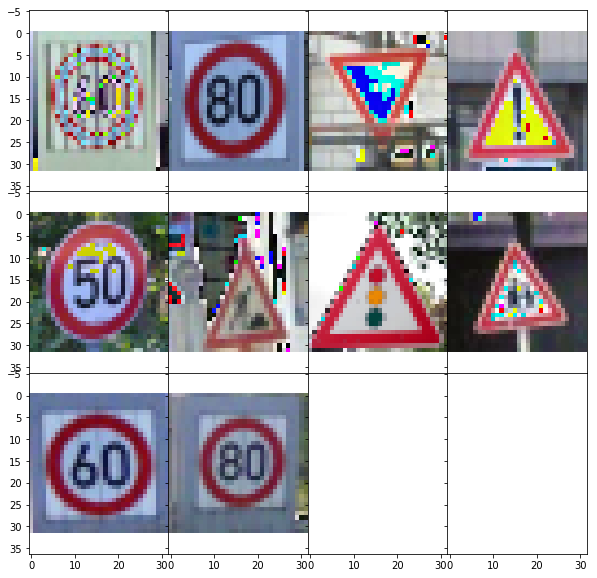

In [69]:
fig, axmx = plt.subplots(3, 4, sharex=True, sharey=True)
fig.subplots_adjust(hspace=0,wspace=0)
fig.set_size_inches(10,10)

for i in range(len(y_test_net)):
    y = math.floor(i/4)
    x = i%4
    axmx[y,x].imshow(X_test_net_norm[i])

### Predict the Sign Type for Each Image

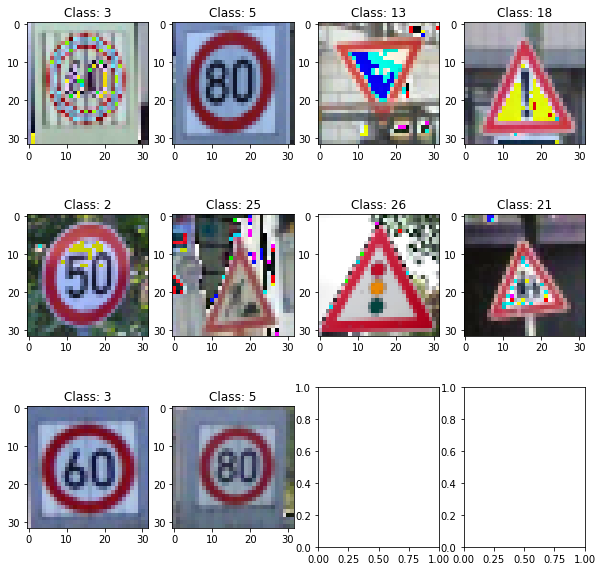

In [76]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    fig, axmx = plt.subplots(3, 4)
    fig.set_size_inches(10,10)

    for i in range(len(y_test_net)):
        y = math.floor(i/4)
        x = i%4
        c = sess.run(tf.argmax(logits, 1),feed_dict={X: [X_test_net_norm[i]], p_keep_prob: 1.0})[0]
        axmx[y,x].imshow(X_test_net_norm[i])
        axmx[y,x].set_title('Class: '+str(c))
        

Children crossing was incorrectly classified. The shrinkage and blurring for children crossing was more than training data so current model could not correctly classified. 

### Analyze Performance

In [91]:
# 10 Images from internet
with tf.Session() as sess:
    # Load best model and evaluate on iamges from internet
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    print("Training:",evaluate(X_train_mod, y_train_mod, 1.0))
    print("Validation:",evaluate(X_valid_norm, y_valid, 1.0))
    print("Test:",evaluate(X_test_norm, y_test, 1.0))
    print("Test Internet:",evaluate(X_test_net_norm, y_test_net, 1.0))

Training: 0.971757516908
Validation: 0.982766450262
Test: 0.955819509752
Test Internet: 0.899999976158


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [96]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    prob = sess.run(tf.nn.softmax(logits),feed_dict={X: X_test_net_norm, p_keep_prob:1.0})
    print(sess.run(tf.nn.top_k(prob, k=5)))

TopKV2(values=array([[  9.99975562e-01,   2.44781240e-05,   4.03081515e-08,
          1.40954766e-13,   7.24397230e-15],
       [  9.93661404e-01,   6.03867229e-03,   2.38598470e-04,
          5.90990676e-05,   1.35333698e-06],
       [  1.00000000e+00,   3.14472040e-08,   3.79812891e-12,
          2.12571865e-12,   1.36741367e-12],
       [  1.00000000e+00,   6.39460381e-13,   2.26107442e-18,
          2.48863606e-24,   3.93909944e-31],
       [  9.99999762e-01,   2.40518403e-07,   1.04886033e-12,
          4.73655512e-13,   2.27605532e-13],
       [  3.31273943e-01,   2.56860971e-01,   1.13844424e-01,
          6.54932186e-02,   6.37054890e-02],
       [  1.00000000e+00,   6.19279628e-12,   3.90816979e-12,
          2.02958039e-14,   1.45988466e-14],
       [  9.97777879e-01,   2.22028559e-03,   1.56961380e-06,
          9.06747530e-08,   7.31480014e-08],
       [  9.99922156e-01,   7.78905014e-05,   1.98681049e-09,
          1.37592940e-13,   3.76741146e-14],
       [  9.99989271e-0

---

## Visualize the Neural Network's State with Test Images


In [136]:
def outputFeatureMap(image_input, activation_name, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    activation = sess.run(activation_name,feed_dict={X: [image_input]})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

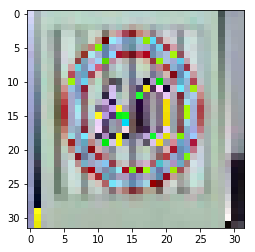

In [140]:
plt.imshow(X_test_net_norm[0])

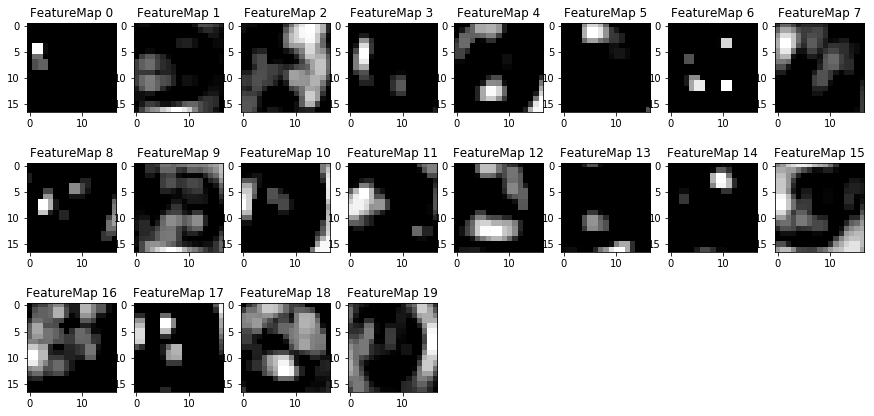

In [141]:
#First Relu After stem
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    #Relu:0, Relu_1:0, Relu_2:0 etc
    outputFeatureMap(X_test_net_norm[0], 'Relu:0', activation_min=-1, activation_max=-1 ,plt_num=1)

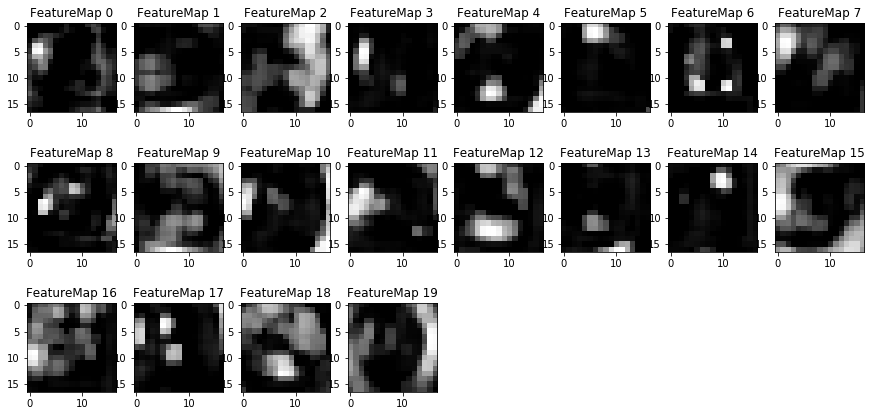

In [138]:
#Relu after Inception-ResNet-B
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    outputFeatureMap(X_test_net_norm[0], 'Relu_1:0', activation_min=-1, activation_max=-1 ,plt_num=1)

Feature map 19 Looks like it can be a 0 as part of "60". The size of "0" in the image is about 17 pixels. Feature map 16 basically looks like a "6". The other feature looks like parts of "6". Combining it together the classifier was basically 100% confident that it was 60 kph speed limit sign. 